In [3]:
!pip install -qq hub

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import hub
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler



In [5]:
!hub login

Please log in using Activeloop credentials. You can register at https://app.activeloop.ai 
Username: henok
Password: 
Login Successful.


## Setup kaggle to work on colab

In [6]:
'''
In order to uplaod the dataset from Kaggle, we need to upload kaggle.json file to the colab. In order to get and upload .json file, follow the below instructions:
1- Go to your Kaggle profile.
2- Click "Edit profile"
3- In API, section click "Create NEW API Token"
4- .json file will be downloaded to your local.
5- To upload .json file, use below code.
'''
from google.colab import files

kaggle_file = files.upload()

Saving kaggle.json to kaggle.json


In [7]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


## Download the different dataset



1.   [Rice Diseases Image Dataset](https://www.kaggle.com/minhhuy2810/rice-diseases-image-dataset)
2.   [Corn or Maize Leaf Disease Dataset](https://www.kaggle.com/smaranjitghose/corn-or-maize-leaf-disease-dataset)
3.   [Cassava Leaf Disease Classification](https://www.kaggle.com/c/cassava-leaf-disease-classification/data)
4.   [Corn Leaf Infection Dataset](https://www.kaggle.com/qramkrishna/corn-leaf-infection-dataset)
5.   [New Plant Diseases Dataset(PlantVillage V2)](https://www.kaggle.com/vipoooool/new-plant-diseases-dataset)

I was having problems downloading compition dataset and found [this stackoverflow](https://stackoverflow.com/questions/58643979/google-colaboratory-use-kaggle-server-version-1-5-6-client-version-1-5-4-fai) thread. The solution is running the next cell.

In [8]:
!pip install -q --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 3.0MB/s 


In [44]:
!kaggle datasets download -d minhhuy2810/rice-diseases-image-dataset
!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset
!kaggle competitions download -c cassava-leaf-disease-classification
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

## Extract and move them to a common folder

In [45]:
!apt-get install tree


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (110 kB/s)
Selecting previously unselected package tree.
(Reading database ... 145480 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [50]:
!du -sh Dataset

35G	Dataset


In [43]:
!mkdir Dataset && cd Dataset
!mkdir cassava && unzip -qq cassava-leaf-disease-classification.zip -d cassava && rm cassava-leaf-disease-classification.zip
!mkdir corn-or-maize-leaf && unzip -qq corn-or-maize-leaf-disease-dataset.zip -d corn-or-maize-leaf && rm corn-or-maize-leaf-disease-dataset.zip
!mkdir plantVillageV2 && unzip -qq new-plant-diseases-dataset.zip -d plantVillageV2 && rm new-plant-diseases-dataset.zip
!mkdir rice && unzip -qq rice-diseases-image-dataset.zip -d rice && rm rice-diseases-image-dataset.zip
!mv cassava/ corn-or-maize-leaf/ plantVillageV2/ rice/ Dataset

In [109]:
# !tree -d Dataset

### Move test and validation set into training folder and make all disese classes on the same directory level

In [83]:
# !rm -r Dataset/cassava/test_images/
# !mv Dataset/corn-or-maize-leaf/data/* Dataset/corn-or-maize-leaf/ && rm -r Dataset/corn-or-maize-leaf/data/
# !mv Dataset/plantVillageV2/New\ Plant\ Diseases\ Dataset\(Augmented\)/New\ Plant\ Diseases\ Dataset\(Augmented\)/* Dataset/plantVillageV2/
# !rm -r Dataset/plantVillageV2/New\ Plant\ Diseases\ Dataset\(Augmented\)
# !mv Dataset/rice/LabelledRice/Labelled/* Dataset/rice && rm -r Dataset/rice/LabelledRice/
# !cp -r Dataset/plantVillageV2/valid/* Dataset/plantVillageV2/train/
pv_path = 'Dataset/plantVillageV2/'
pv_train = os.path.join(pv_path, 'train')
pv_valid = os.path.join(pv_path, 'valid')
for p in os.listdir(pv_valid):
  path = os.path.join(pv_valid, p)
  # print(path)
  for f in os.listdir(path):
    source_path = os.path.join(path, f)
    dest_path = os.path.join(os.path.join(pv_train, p), 'v'+f)
    os.replace(source_path, dest_path)
    # print(source_path, dest_path)
!rm -r Dataset/plantVillageV2/valid/


In [110]:
# !tree -d Dataset

In [86]:
import csv
import pandas as pd
import json

In [87]:
num_class_map = {}
with open('Dataset/cassava/label_num_to_disease_map.json') as f:
  num_class_map = json.load(f)
  


In [94]:
with open('Dataset/cassava/train.csv', 'r') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  line_count = 0
  zero, one, two, three, four = 0, 0, 0, 0, 0
  for row in csv_reader:
    if line_count == 0:
      print(f'Column names are {", ".join(row)}')
      line_count += 1
    else:
      if row[1]=='0':
        zero+=1
      elif row[1]=='1':
        one+=1
      elif row[1]=='2':
        two+=1
      elif row[1]=='3':
        three+=1
      elif row[1]=='4':
        four+=1
      # print(f'\t{row[0]}\t{row[1]}')
      file_name = row[0]
      label = num_class_map[row[1]]
      os.rename('Dataset/cassava/train_images/'+file_name, 'Dataset/cassava/train_images/'+label+'/'+file_name)
      line_count += 1
  print(zero, one, two,three, four)
  print(sum((zero, one, two,three, four)))

Column names are image_id, label
1087 2189 2386 13158 2577
21397


In [89]:
for key in num_class_map:
  os.mkdir('Dataset/cassava/train_images/' + num_class_map[key])

In [95]:
!du -sh Dataset/cassava/train_images/*

110M	Dataset/cassava/train_images/Cassava Bacterial Blight (CBB)
220M	Dataset/cassava/train_images/Cassava Brown Streak Disease (CBSD)
278M	Dataset/cassava/train_images/Cassava Green Mottle (CGM)
1.6G	Dataset/cassava/train_images/Cassava Mosaic Disease (CMD)
275M	Dataset/cassava/train_images/Healthy


In [104]:
def prepend_dir(base_path, prepend):
  
  for path in os.listdir(base_path):
    old_path = os.path.join(base_path, path)
    new_path = os.path.join(base_path, prepend +path)
    os.rename(old_path, new_path)

# corn_path = "Dataset/corn-or-maize-leaf"
# corn_prepend = "Corn_"
# prepend_dir(corn_path, corn_prepend)
# rice_path = "Dataset/rice"
# rice_prepend = "Rice_"
# prepend_dir(rice_path, rice_prepend)
# !mv Dataset/cassava/train_images/Healthy Dataset/cassava/train_images/Cassava\ Healthy
!mv Dataset/cassava/train_images/* Dataset/

In [117]:
corn_gray_leaf_source = 'Dataset/corn-or-maize-leaf/Corn_Gray_Leaf_Spot/'
corn_gray_leaf_des = 'Dataset/plantVillageV2/train/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/'
corn_healty_source = 'Dataset/corn-or-maize-leaf/Corn_Healthy/'
corn_healty_des = 'Dataset/plantVillageV2/train/Corn_(maize)___healthy/'
# pv_train = os.path.join(pv_path, 'train')
# pv_valid = os.path.join(pv_path, 'valid')
def move_files(source, destination):
  """
  moves all files in the source dir to destination dir 
  """
  for file_name in os.listdir(source):
    source_dir = os.path.join(source, file_name)
    des_dir = os.path.join(destination, file_name)
    os.replace(source_dir, des_dir)

# move_files(corn_gray_leaf_source, corn_gray_leaf_des)
# move_files(corn_healty_source, corn_healty_des)
!rm -r $corn_gray_leaf_source $corn_healty_source

### Visualize sample images from each dataset to see it they are from fields or not
TODO

In [122]:
# !mv Dataset/cassava/train_images/* Dataset/corn-or-maize-leaf/* Dataset/plantVillageV2/train/* Dataset/rice/* Dataset/
# !rm -r Dataset/cassava/ Dataset/corn-or-maize-leaf/ Dataset/plantVillageV2 Dataset/rice
!mv Dataset/train_images/* Dataset && rm -r Dataset/train_images/
!tree -d Dataset/

Dataset/
├── Apple___Apple_scab
├── Apple___Black_rot
├── Apple___Cedar_apple_rust
├── Apple___healthy
├── Blueberry___healthy
├── Cassava Bacterial Blight (CBB)
├── Cassava Brown Streak Disease (CBSD)
├── Cassava Green Mottle (CGM)
├── Cassava Healthy
├── Cassava Mosaic Disease (CMD)
├── Cherry_(including_sour)___healthy
├── Cherry_(including_sour)___Powdery_mildew
├── Corn_Blight
├── Corn_Common_Rust
├── Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
├── Corn_(maize)___Common_rust_
├── Corn_(maize)___healthy
├── Corn_(maize)___Northern_Leaf_Blight
├── Grape___Black_rot
├── Grape___Esca_(Black_Measles)
├── Grape___healthy
├── Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
├── Orange___Haunglongbing_(Citrus_greening)
├── Peach___Bacterial_spot
├── Peach___healthy
├── Pepper,_bell___Bacterial_spot
├── Pepper,_bell___healthy
├── Potato___Early_blight
├── Potato___healthy
├── Potato___Late_blight
├── Raspberry___healthy
├── Rice_BrownSpot
├── Rice_Healthy
├── Rice_Hispa
├── Rice_LeafBlast

In [127]:
!rm Dataset/*.csv Dataset/*.json

In [128]:
folders_count = {}
for folder in os.listdir('Dataset'):
  folders_count[folder] = len(os.listdir(os.path.join('Dataset', folder)))

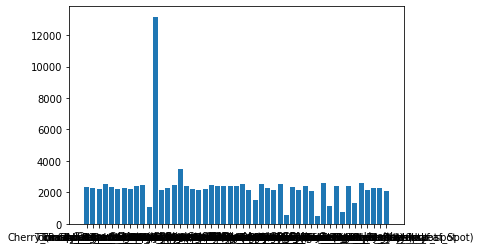

In [129]:
plt.bar(range(len(folders_count)), list(folders_count.values()), align='center')
plt.xticks(range(len(folders_count)), list(folders_count.keys()))

plt.show()

In [ ]:
total_samples = 0
for key in folders_count:
  total_samples += folders_count[key]
print("The dataset has {} samples".format(total_samples))

## Creates a hub dataset skeleton and Upload the dataset

In [133]:
from hub.schema import ClassLabel, Image

my_schema = {
    "image": Image((256, 256, 3), dtype="uint8",),
    "label": ClassLabel(names=os.listdir('Dataset')),
}

url = "henok/omdena_plant_disease_ds" #instead write your {username}/{dataset} to make it public

ds = hub.Dataset(url, 
                 shape=(total_samples,), 
                 schema=my_schema, mode='w')


In [146]:
ds_path = 'Dataset'
classes = os.listdir(ds_path)
i = 0
for label, idx in zip(classes, range(len(classes))):
  # print(label)
  label_path = os.path.join(ds_path, label)
  for file_name in os.listdir(label_path):
    image = cv2.resize(cv2.imread(os.path.join(label_path, file_name)), (256, 256))
    ds["image", i] = image
    ds["label", i] = idx
    i+=1


In [148]:
ds.commit()

## Train a model
TODO 

In [150]:
import tensorflow as tf


In [154]:
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [1]:
# model.summary()

(256, 256, 3)
4


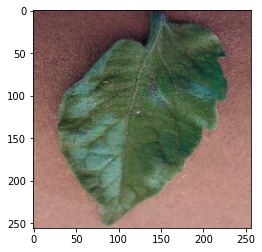

In [172]:
ds = hub.Dataset('henok/omdena_plant_disease_ds')
ds_img = ds["image"][10000].numpy()
plt.imshow(ds_img)
print(ds["image"][10000].numpy().shape)
print(ds["label", 10000].numpy())

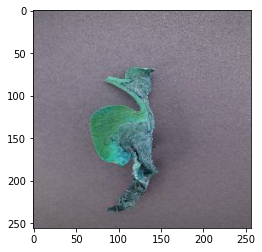

In [168]:
plt.imshow(ds["image"][1].numpy())

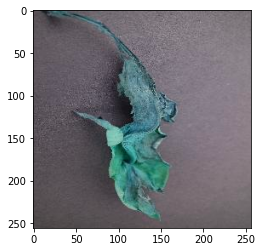

In [164]:
cs = os.listdir('Dataset')
fs = os.listdir(os.path.join('Dataset', cs[0]))
img = cv2.imread('Dataset/'+cs[0]+'/'+fs[0])
plt.imshow(img)